# 2D Parameter Scan

This notebook gives an example calculation and visualisation of detachment front location sensitivity, i.e. how fast will the front move through different regions of the domain depending on the magnetic topology. Front movement is proportional to the fractional B field gradient: the sharper the gradient as a proportion of the B field at that point (see Cowley 2022 for more details). This means the sharper the gradient and the lower the B field, the slower the front movement.

In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator, PercentFormatter

%matplotlib inline

## Read and visualise equilibrium
- V10 inner and outer, visualised.

<Axes: xlabel='$S_{\\parallel}$ (m from target)', ylabel='$B_{tot}$ (T)'>

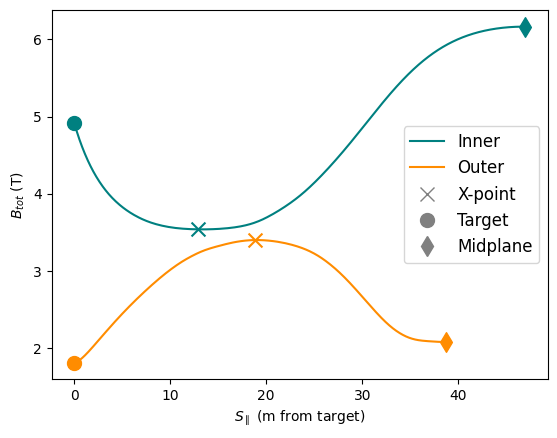

In [2]:
from fusiondls import file_read
from fusiondls.plot import plot_B_field_profile

eqb = file_read("eqb_store.pkl")
design = eqb["V10"]  # Pick design to use for study

inner = design["iu"]
outer = design["ou"]
plot_B_field_profile(
    inner["S"],
    inner["Btot"],
    inner["Xpoint"],
    outer["S"],
    outer["Btot"],
    outer["Xpoint"],
)

## Run basic density scan on both the inner and the outer

### Set DLS defaults

In [3]:
from fusiondls.AnalyticCoolingCurves import LfuncKallenbachAr

# set switches
radios = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
}

# set general run parameters
constants_default = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 1e9,  # heat flux density at the x point
    "nu": 1e20,  # Upstream density (if constant)
    "nu0": 1e20,  # Upstream density (if constant)
    "cz0": 0.05,  # Impurity fraction (if constant)
    "Lfunc": LfuncKallenbachAr,  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

### Run
- Running a grid of flux expansion and connection length combinations between Xpoint and target. 
- Note that the inner is set to the same power as the outer here. 
- Reducing the inner power to 10% of the outer like the previous studies leads to numerical issues which are still being investigated.
- Also note that this is using the STEP V10 profiles.

If you don't want to do the run, you can read in the results in the next cell.

In [4]:
from fusiondls import file_read, file_write, make_arrays, run_dls
from fusiondls.DLScommonTools import scale_BxBt, scale_Lc

store = {}

N = 4
list_BxBt_scales = np.append(
    np.linspace(0.25, 1.0, N, endpoint=False), np.linspace(1.0, 2.5, N)
)
list_Lc_scales = np.append(
    np.linspace(0.25, 1.0, N, endpoint=False), np.linspace(1.0, 2.5, N)
)

for side in ["iu", "ou"]:
    store[side] = []
    for BxBt_scale in list_BxBt_scales:
        result_row = []
        for Lc_scale in list_Lc_scales:
            print(
                f"Running side '{side}', BxBt scale: {BxBt_scale:.2f}, Lc scale: {Lc_scale:.2f}"
            )

            d = copy.deepcopy(design[side])
            constants = constants_default.copy()

            d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor=BxBt_scale)
            d["S"], d["Spol"] = scale_Lc(
                d["S"], d["Spol"], d["Xpoint"], scale_factor=Lc_scale
            )

            SparRange = [0, d["S"][d["Xpoint"] - 1]]
            result_row.append(
                run_dls(constants, radios, d, SparRange, control_variable="density")
            )

        store[side].append(result_row)

store["list_BxBt_scales"] = list_BxBt_scales
store["list_Lc_scales"] = list_Lc_scales

Running side 'iu', BxBt scale: 0.25, Lc scale: 0.25
Solving...0.00...3.14...

/home/peter/Codes/DLS-model/src/fusiondls/Iterate.py:89: RuntimeWarning: invalid value encountered in scalar power
  dtds = qoverB * fieldValue / (kappa0 * T ** (5 / 2))


Complete in 0.8 seconds
Running side 'iu', BxBt scale: 0.25, Lc scale: 0.44
Solving...0.00...5.49...Complete in 0.7 seconds
Running side 'iu', BxBt scale: 0.25, Lc scale: 0.62
Solving...0.00...7.84...Complete in 0.6 seconds
Running side 'iu', BxBt scale: 0.25, Lc scale: 0.81
Solving...0.00...10.19...Complete in 0.9 seconds
Running side 'iu', BxBt scale: 0.25, Lc scale: 1.00
Solving...0.00...12.54...Complete in 0.9 seconds
Running side 'iu', BxBt scale: 0.25, Lc scale: 1.50
Solving...0.00...18.82...Complete in 0.9 seconds
Running side 'iu', BxBt scale: 0.25, Lc scale: 2.00
Solving...0.00...25.09...Complete in 0.9 seconds
Running side 'iu', BxBt scale: 0.25, Lc scale: 2.50
Solving...0.00...31.36...Complete in 0.9 seconds
Running side 'iu', BxBt scale: 0.44, Lc scale: 0.25
Solving...0.00...3.14...Complete in 0.8 seconds
Running side 'iu', BxBt scale: 0.44, Lc scale: 0.44
Solving...0.00...5.49...Complete in 0.7 seconds
Running side 'iu', BxBt scale: 0.44, Lc scale: 0.62
Solving...0.00...7.

### Read/write

In [5]:
file_write(store, "2dscan_v10_density_kAr.pkl")

## 2D Contour plot
- X axis: change in connection length
- Y axis: change in flux expansion
- The colour scale indicates threshold improvement (i.e. threshold reduction)
- Illustrates nonlinearity in impact of both parameters
- On the inner, there is a "blank" space at the bottom. This illustrates the region of unstable solutions.
    - FIXME: This was coming from cutting off the plot at -5% -- should this be retained?

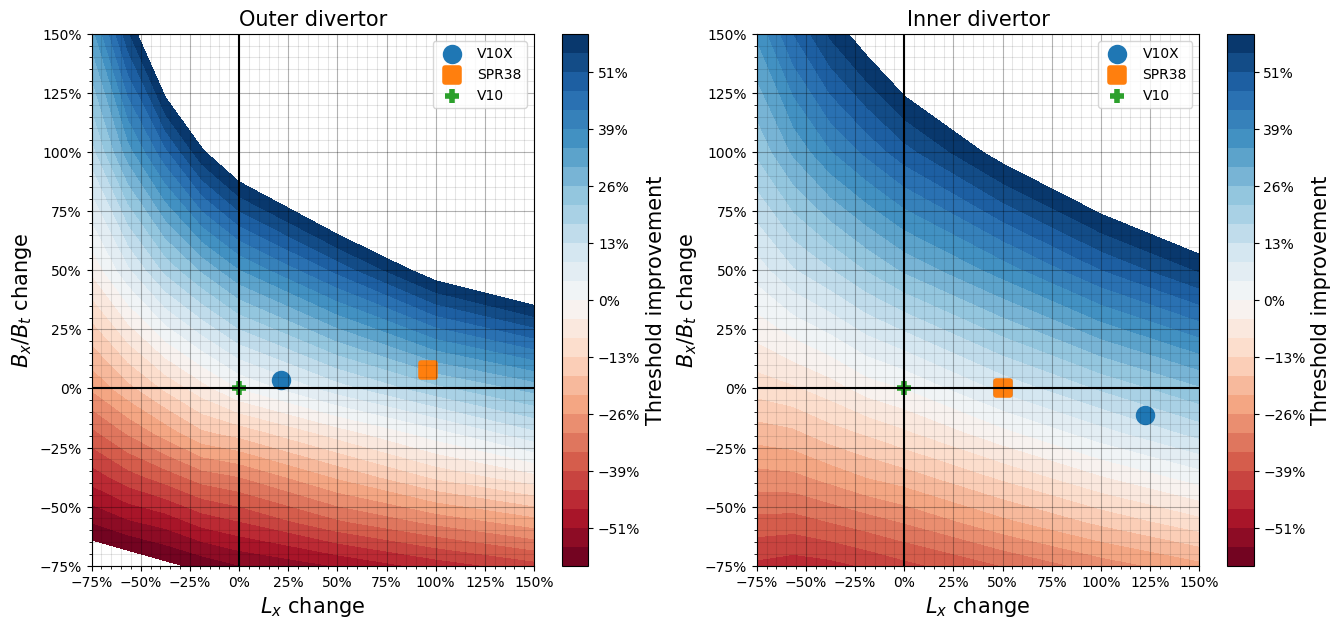

In [6]:
def plot_threshold_improvement(ax, name, profiles, v10x_point, spr38_point):
    levels = np.linspace(-0.6, 0.6, 29)
    cs = ax.contourf(
        list_Lc_scales - 1,
        list_BxBt_scales - 1,
        1 / (profiles["threshold_norm"] + 1) - 1,
        levels=levels,
        cmap="RdBu",
    )
    cb = fig.colorbar(cs, ax=ax, format="{x:.0%}")
    cb.set_label(label="Threshold improvement", size=15)
    ax.set_title(f"{name} divertor", fontsize=15)

    ax.set_xlim(-0.75, 1.5)
    ax.set_ylim(-0.75, 1.5)
    ax.hlines(0, -0.75, 1.5, color="black")
    ax.vlines(0, -0.75, 1.5, color="black")
    ax.grid(color="black", alpha=0.3, which="major")
    ax.grid(color="black", alpha=0.1, which="minor")
    ax.set_xlabel("$L_x$ change", fontsize=15)
    ax.set_ylabel("$B_x/B_t$ change", fontsize=15)
    for axis in (ax.xaxis, ax.yaxis):
        axis.set_major_formatter(PercentFormatter(1.0))
        axis.set_minor_locator(MultipleLocator(0.05))
        axis.set_major_locator(MultipleLocator(0.25))

    marker_style = {"s": 100, "linewidth": 4}
    ax.scatter(*v10x_point, marker="o", label="V10X", **marker_style)
    ax.scatter(*spr38_point, marker="s", label="SPR38", **marker_style)
    ax.scatter([0], [0], marker="+", label="V10", **marker_style)
    ax.legend(loc="upper right")


outer = make_arrays(store["ou"], list_BxBt_scales, list_Lc_scales, cut=False)
inner = make_arrays(store["iu"], list_BxBt_scales, list_Lc_scales, cut=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.tight_layout(pad=5)

outer_v10x_point = ([1.213 - 1], [1.037 - 1])
outer_spr38_point = ([1.959 - 1], [1.080 - 1])
plot_threshold_improvement(axes[0], "Outer", outer, outer_v10x_point, outer_spr38_point)

inner_v10x_point = ([2.226 - 1], [0.889 - 1])
inner_spr38_point = ([1.501 - 1], [1 - 1])
plot_threshold_improvement(axes[1], "Inner", inner, inner_v10x_point, inner_spr38_point)